# Carga de ambiente

In [1]:
import numpy as np
import pandas as pd

import os
import sys
import pickle 

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
# Configurar gráficos
plt.style.use('default')
plt.rcParams.update({'figure.max_open_warning': 0})


import statsmodels.formula.api as smf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Carga de Datos

In [2]:
df = pd.read_csv('ecommerce_orders.csv')

In [3]:
df.head()

,order_id,order_date,customer_id,product_id,product_category,vendor_id,vendor_name,price,quantity,revenue
0,10000,2022-01-01,C1081,P205,Pharma,V001,Vendor A,32.48,3,97.44
1,10001,2022-01-01,C1094,P255,Pharma,V002,Vendor B,89.29,4,357.16
2,10002,2022-01-01,C1028,P261,Pharma,V001,Vendor A,21.65,2,43.30
3,10003,2022-01-01,C1086,E199,Electronics,V001,Vendor A,478.49,2,956.98
4,10004,2022-01-01,C1075,E138,Electronics,V001,Vendor A,214.19,4,856.76


In [4]:
df[df['product_id'] == 'P205']

,order_id,order_date,customer_id,product_id,product_category,vendor_id,vendor_name,price,quantity,revenue
0,10000,2022-01-01,C1081,P205,Pharma,V001,Vendor A,32.48,3,97.44
5,10005,2022-01-01,C1003,P205,Pharma,V002,Vendor B,61.98,4,247.92
15,10015,2022-01-01,C1048,P205,Pharma,V003,Vendor C,40.70,4,162.80
38,10038,2022-01-02,C1011,P205,Pharma,V001,Vendor A,75.58,4,302.32
43,10043,2022-01-03,C1087,P205,Pharma,V003,Vendor C,71.82,1,71.82
...,...,...,...,...,...,...,...,...,...,...
16360,26360,2023-12-29,C1047,P205,Pharma,V004,Vendor D,79.06,5,395.30
16395,26395,2023-12-30,C1018,P205,Pharma,V001,Vendor A,74.62,4,298.48
16400,26400,2023-12-30,C1098,P205,Pharma,V003,Vendor C,73.49,1,73.49
16416,26416,2023-12-31,C1084,P205,Pharma,V004,Vendor D,29.65,5,148.25


In [5]:
# %% [markdown]
# # Análisis Exploratorio de Datos (EDA) en Profundidad
# 
# En este notebook exploramos el dataset `ecommerce_orders.csv` abarcando:
# 
# 1. **Visión General:** Resumen de la información del dataset, estadísticas descriptivas y estructura de los datos.
# 2. **Análisis por Categoría de Producto:** Tendencias mensuales de ingresos, cantidad de pedidos y evolución porcentual para identificar comportamientos (por ejemplo, desaceleración en Electronics).
# 3. **Análisis por Vendedor:** Desempeño global y mensual de los vendedores, identificando posibles desaceleraciones o comportamientos atípicos.
# 4. **Análisis de Clientes:** Número de clientes únicos por mes, distribución de ingresos por cliente y patrones de recurrencia.
# 5. **Análisis de Características de Pedidos:** Distribución de precios, cantidades y revenue por pedido, además de la correlación entre variables.
# 
# Este análisis se estructura para obtener un entendimiento holístico de la evolución de las ventas y detectar áreas críticas que requieran intervención.



In [6]:

# Convertir 'order_date' a datetime y crear columnas adicionales para análisis temporal
df['order_date'] = pd.to_datetime(df['order_date'])
df['month'] = df['order_date'].dt.to_period('M').dt.to_timestamp()
df['year'] = df['order_date'].dt.year
df['day'] = df['order_date'].dt.date


In [7]:

# Visualizar las primeras filas y estructura
print("Dimensiones del dataset:", df.shape)
print("\nPrimeras filas:")
df.head()

Dimensiones del dataset: (16420, 13)

Primeras filas:


,order_id,order_date,customer_id,product_id,product_category,vendor_id,vendor_name,price,quantity,revenue,month,year,day
0,10000,2022-01-01,C1081,P205,Pharma,V001,Vendor A,32.48,3,97.44,2022-01-01,2022,2022-01-01
1,10001,2022-01-01,C1094,P255,Pharma,V002,Vendor B,89.29,4,357.16,2022-01-01,2022,2022-01-01
2,10002,2022-01-01,C1028,P261,Pharma,V001,Vendor A,21.65,2,43.30,2022-01-01,2022,2022-01-01
3,10003,2022-01-01,C1086,E199,Electronics,V001,Vendor A,478.49,2,956.98,2022-01-01,2022,2022-01-01
4,10004,2022-01-01,C1075,E138,Electronics,V001,Vendor A,214.19,4,856.76,2022-01-01,2022,2022-01-01


In [8]:

# 1. Visión General y Estadísticas Descriptivas

# Revisamos la estructura, tipos de datos y estadísticas descriptivas para entender la calidad y distribución de la información.

print("Información del dataset:")
print(df.info())

print("\nEstadísticas descriptivas numéricas:")
display(df.describe())


Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16420 entries, 0 to 16419
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   order_id          16420 non-null  int64         
 1   order_date        16420 non-null  datetime64[ns]
 2   customer_id       16420 non-null  object        
 3   product_id        16420 non-null  object        
 4   product_category  16420 non-null  object        
 5   vendor_id         16420 non-null  object        
 6   vendor_name       16420 non-null  object        
 7   price             16420 non-null  float64       
 8   quantity          16420 non-null  int64         
 9   revenue           16420 non-null  float64       
 10  month             16420 non-null  datetime64[ns]
 11  year              16420 non-null  int32         
 12  day               16420 non-null  object        
dtypes: datetime64[ns](2), float64(2), int32(1), int64(2

,order_id,order_date,price,quantity,revenue,month,year
count,16420.000000,16420,16420.000000,16420.000000,16420.000000,16420,16420.000000
mean,18209.500000,2023-01-22 21:19:20.243605248,161.819535,3.016443,488.781115,2023-01-08 04:10:38.440925696,2022.561693
min,10000.000000,2022-01-01 00:00:00,20.000000,1.000000,20.000000,2022-01-01 00:00:00,2022.000000
25%,14104.750000,2022-07-26 00:00:00,52.700000,2.000000,130.320000,2022-07-01 00:00:00,2022.000000
50%,18209.500000,2023-02-08 00:00:00,86.280000,3.000000,272.195000,2023-02-01 00:00:00,2023.000000
75%,22314.250000,2023-07-23 00:00:00,271.620000,4.000000,680.110000,2023-07-01 00:00:00,2023.000000
max,26419.000000,2023-12-31 00:00:00,499.730000,5.000000,2497.550000,2023-12-01 00:00:00,2023.000000
std,4740.190045,NaN,141.283130,1.417860,524.362976,NaN,0.496194


In [9]:
# 2. Análisis por Categoría de Producto

# Agregar ingresos y cantidad de pedidos por mes y categoría
monthly_cat = df.groupby(['month', 'product_category'])['revenue'].sum().reset_index()
orders_cat = df.groupby(['month', 'product_category'])['order_id'].nunique().reset_index()
quant_cat = df.groupby(['month', 'product_category'])['quantity'].sum().reset_index()



# EDA

## Exploratorio Product_Category

### Categoría - Ingresos 

In [10]:
monthly_cat = df.groupby(['month', 'product_category'])['revenue'].sum().reset_index()

# Crear figura Plotly
fig = go.Figure()

for cat in monthly_cat["product_category"].unique():
    subset = monthly_cat[monthly_cat["product_category"] == cat]

    # Línea de ingresos mensuales
    fig.add_trace(go.Scatter(
        x=subset["month"],
        y=subset["revenue"],
        mode="lines+markers",
        name=f"{cat} - Ingresos"
    ))

    # Línea de tendencia desde enero 2023
    subset_2023 = subset[subset["month"] >= "2023-01-01"]
    if len(subset_2023) >= 2:
        x_vals = subset_2023["month"].map(pd.Timestamp.toordinal)
        y_vals = subset_2023["revenue"]
        slope, intercept = np.polyfit(x_vals, y_vals, 1)
        trendline = slope * x_vals + intercept

        fig.add_trace(go.Scatter(
            x=subset_2023["month"],
            y=trendline,
            mode="lines",
            name=f"{cat} - Tendencia",
            line=dict(dash="dash")
        ))

# Layout
fig.update_layout(
    title="Evolución Mensual de Ingresos por Categoría",
    xaxis_title="Mes",
    yaxis_title="Ingresos Totales (USD)",
    legend_title="Categoría",
    height=600
)

fig.show()


### Categoría - # de Ordenes

In [11]:
orders_cat = df.groupby(['month', 'product_category'])['order_id'].nunique().reset_index()

# Crear figura Plotly
fig = go.Figure()

for cat in orders_cat["product_category"].unique():
    subset = orders_cat[orders_cat["product_category"] == cat]

    # Línea de ingresos mensuales
    fig.add_trace(go.Scatter(
        x=subset["month"],
        y=subset["order_id"],
        mode="lines+markers",
        name=f"{cat} - Ingresos"
    ))

    # Línea de tendencia desde enero 2023
    subset_2023 = subset[subset["month"] >= "2023-01-01"]
    if len(subset_2023) >= 2:
        x_vals = subset_2023["month"].map(pd.Timestamp.toordinal)
        y_vals = subset_2023["order_id"]
        slope, intercept = np.polyfit(x_vals, y_vals, 1)
        trendline = slope * x_vals + intercept

        fig.add_trace(go.Scatter(
            x=subset_2023["month"],
            y=trendline,
            mode="lines",
            name=f"{cat} - Tendencia",
            line=dict(dash="dash")
        ))

# Layout
fig.update_layout(
    title="Evolución Mensual de Ordenes por Categoría",
    xaxis_title="Mes",
    yaxis_title="Ordenes",
    legend_title="Categoría",
    height=600
)

fig.show()


### Categoría - Volumen de Venta

In [12]:
quant_cat = df.groupby(['month', 'product_category'])['quantity'].sum().reset_index()

# Crear figura Plotly
fig = go.Figure()

for cat in quant_cat["product_category"].unique():
    subset = quant_cat[quant_cat["product_category"] == cat]

    # Línea de ingresos mensuales
    fig.add_trace(go.Scatter(
        x=subset["month"],
        y=subset["quantity"],
        mode="lines+markers",
        name=f"{cat} - Volumen"
    ))

    # Línea de tendencia desde enero 2023
    subset_2023 = subset[subset["month"] >= "2023-01-01"]
    if len(subset_2023) >= 2:
        x_vals = subset_2023["month"].map(pd.Timestamp.toordinal)
        y_vals = subset_2023["quantity"]
        slope, intercept = np.polyfit(x_vals, y_vals, 1)
        trendline = slope * x_vals + intercept

        fig.add_trace(go.Scatter(
            x=subset_2023["month"],
            y=trendline,
            mode="lines",
            name=f"{cat} - Tendencia",
            line=dict(dash="dash")
        ))

# Layout
fig.update_layout(
    title="Evolución Mensual de Volumen de Venta por Categoría",
    xaxis_title="Mes",
    yaxis_title="Volumen de Venta",
    legend_title="Categoría",
    height=600
)

fig.show()


### Categoría - Precio Promedio

In [13]:
price_cat = df.groupby(['month', 'product_category'])['price'].mean().reset_index()


# Crear figura Plotly
fig = go.Figure()

for cat in price_cat["product_category"].unique():
    subset = price_cat[price_cat["product_category"] == cat]

    # Línea de ingresos mensuales
    fig.add_trace(go.Scatter(
        x=subset["month"],
        y=subset["price"],
        mode="lines+markers",
        name=f"{cat} - Precio Promedio"
    ))

    # Línea de tendencia desde enero 2023
    subset_2023 = subset[subset["month"] >= "2023-06-01"]
    if len(subset_2023) >= 2:
        x_vals = subset_2023["month"].map(pd.Timestamp.toordinal)
        y_vals = subset_2023["price"]
        slope, intercept = np.polyfit(x_vals, y_vals, 1)
        trendline = slope * x_vals + intercept

        fig.add_trace(go.Scatter(
            x=subset_2023["month"],
            y=trendline,
            mode="lines",
            name=f"{cat} - Tendencia",
            line=dict(dash="dash")
        ))

# Layout
fig.update_layout(
    title="Evolución Mensual de Precio Promedio por Categoría",
    xaxis_title="Mes",
    yaxis_title="Precio Promedio",
    legend_title="Categoría",
    height=600
)

fig.show()


## Análisis de  'Electronics'

In [14]:
# Filtrar solo la categoría Electronics
electronics_df = df[df["product_category"] == "Electronics"]

### Vendor - Share de Ingresos 

In [15]:
# Calcular revenue mensual por producto
y_product_revenue = electronics_df.groupby(["year", "vendor_id"])["revenue"].sum().reset_index()

# Calcular share mensual por producto
y_total_revenue = y_product_revenue.groupby("year")["revenue"].transform("sum")
y_product_revenue["share"] = y_product_revenue["revenue"] / y_total_revenue


In [16]:
y_product_revenue

,year,vendor_id,revenue,share
0,2022,V001,706048.16,0.256161
1,2022,V002,671152.64,0.243500
2,2022,V003,699750.25,0.253876
3,2022,V004,679320.07,0.246463
4,2023,V001,882974.44,0.253356
5,2023,V002,808311.59,0.231933
6,2023,V003,849014.92,0.243612
7,2023,V004,944812.54,0.271100


In [17]:

# Calcular revenue mensual por producto
monthly_product_revenue = electronics_df.groupby(["month", "vendor_id"])["revenue"].sum().reset_index()

# Calcular share mensual por producto
monthly_total_revenue = monthly_product_revenue.groupby("month")["revenue"].transform("sum")
monthly_product_revenue["share"] = monthly_product_revenue["revenue"] / monthly_total_revenue

# Visualizar en gráfico apilado de áreas
fig = px.area(
    monthly_product_revenue,
    x="month",
    y="share",
    color="vendor_id",
    title="Participación mensual (share) por Vendor en Electronics",
    labels={"share": "Participación (%)", "month": "Mes", "vendor_id": "Vendor"},
    groupnorm="fraction"
)

fig.update_layout(height=600, legend_title_text="ID Producto")
fig.show()


### Producto - Volumen de Ventas Mensual

In [18]:
# Calcular volumen mensual por producto (suma de quantity)
monthly_volume_product = electronics_df.groupby(["month", "product_id"])["quantity"].sum().reset_index()

# Visualización
fig = px.line(
    monthly_volume_product,
    x="month",
    y="quantity",
    color="product_id",
    title="Volumen de ventas mensual por producto (Electronics)",
    labels={"month": "Mes", "quantity": "Unidades Vendidas", "product_id": "Producto"},
    markers=True
)

fig.update_layout(height=600, legend_title_text="ID Producto")
fig.show()

### Producto - Share de Ingresos

In [19]:

# Calcular revenue mensual por producto
monthly_product_revenue = electronics_df.groupby(["month", "product_id"])["revenue"].sum().reset_index()

# Calcular share mensual por producto
monthly_total_revenue = monthly_product_revenue.groupby("month")["revenue"].transform("sum")
monthly_product_revenue["share"] = monthly_product_revenue["revenue"] / monthly_total_revenue

# Visualizar en gráfico apilado de áreas
fig = px.area(
    monthly_product_revenue,
    x="month",
    y="share",
    color="product_id",
    title="Participación mensual (share) por producto en Electronics",
    labels={"share": "Participación (%)", "month": "Mes", "product_id": "Producto"},
    groupnorm="fraction"
)

fig.update_layout(height=600, legend_title_text="ID Producto")
fig.show()


### Producto - Precio Promedio 

In [20]:

# Calcular el precio promedio mensual por producto
monthly_price_product = electronics_df.groupby(["month", "product_id"])["price"].mean().reset_index()

# Visualizar con gráfico de línea interactivo
fig = px.line(
    monthly_price_product,
    x="month",
    y="price",
    color="product_id",
    title="Evolución mensual del precio promedio por producto (Electronics)",
    labels={"month": "Mes", "price": "Precio Promedio (USD)", "product_id": "Producto"},
    markers=True
)

fig.update_layout(height=600, legend_title_text="ID Producto")
fig.show()


### Vendor - Ingresos 

In [21]:


# Agrupar ingresos mensuales por vendedor
monthly_vendor = electronics_df.groupby(["month", "vendor_name"])["revenue"].sum().reset_index()

# Crear figura
fig = go.Figure()

for vendor in monthly_vendor["vendor_name"].unique():
    vendor_data = monthly_vendor[monthly_vendor["vendor_name"] == vendor]

    # Línea de ingresos
    fig.add_trace(go.Scatter(
        x=vendor_data["month"],
        y=vendor_data["revenue"],
        mode="lines+markers",
        name=f"{vendor} - Ingresos"
    ))

    # Línea de tendencia desde enero 2023
    vendor_2023 = vendor_data[vendor_data["month"] >= "2023-06-01"]
    if len(vendor_2023) >= 2:
        x_vals = vendor_2023["month"].map(pd.Timestamp.toordinal)
        y_vals = vendor_2023["revenue"]
        slope, intercept = np.polyfit(x_vals, y_vals, 1)
        trendline = slope * x_vals + intercept

        fig.add_trace(go.Scatter(
            x=vendor_2023["month"],
            y=trendline,
            mode="lines",
            name=f"{vendor} - Tendencia",
            line=dict(dash="dash")
        ))

# Configuración del gráfico
fig.update_layout(
    title="Evolución Mensual de Ingresos por Vendedor (Electronics)",
    xaxis_title="Mes",
    yaxis_title="Ingresos (USD)",
    height=700,
    legend_title="Vendedor"
)

fig.show()


In [22]:

target_vendors = electronics_df[electronics_df["vendor_id"].isin(["V001", "V003"])]

# Agrupar por mes y vendor
monthly_revenue = target_vendors.groupby(["vendor_id", "month"]).agg(
    revenue=("revenue", "sum")
).reset_index()

# Filtrar meses de junio a diciembre 2023
mask = (monthly_revenue["month"] >= "2023-06-01") & (monthly_revenue["month"] <= "2023-12-01")
monthly_revenue_2H2023 = monthly_revenue[mask]

# Calcular caída en revenue entre junio y diciembre por vendor
june_revenue = monthly_revenue_2H2023[monthly_revenue_2H2023["month"] == "2023-06-01"]
dec_revenue = monthly_revenue_2H2023[monthly_revenue_2H2023["month"] == "2023-12-01"]

# Unir y calcular variación
comparison = pd.merge(june_revenue, dec_revenue, on="vendor_id", suffixes=("_jun", "_dec"))
comparison["revenue_drop_pct"] = (comparison["revenue_dec"] - comparison["revenue_jun"]) / comparison["revenue_jun"]

comparison


,vendor_id,month_jun,revenue_jun,month_dec,revenue_dec,revenue_drop_pct
0,V001,2023-06-01,81073.75,2023-12-01,59185.63,-0.269978
1,V003,2023-06-01,69669.54,2023-12-01,55191.38,-0.207812


In [23]:
#Caída del Revenue del 27% para el vendor V001
#Caída del Revenue del 20.7% para el vendor V003

### Vendor - Precio Promedio

In [24]:

# Calcular precio promedio mensual por vendedor
monthly_vendor_price = electronics_df.groupby(["month", "vendor_name"])["price"].mean().reset_index()

# Crear figura
fig = go.Figure()

for vendor in monthly_vendor_price["vendor_name"].unique():
    subset = monthly_vendor_price[monthly_vendor_price["vendor_name"] == vendor]

    # Línea original de precios
    fig.add_trace(go.Scatter(
        x=subset["month"],
        y=subset["price"],
        mode="lines+markers",
        name=f"{vendor} - Precio promedio"
    ))

    # Línea de tendencia desde enero 2023
    subset_2023 = subset[subset["month"] >= "2023-06-01"]
    if len(subset_2023) >= 2:
        x_vals = subset_2023["month"].map(pd.Timestamp.toordinal)
        y_vals = subset_2023["price"]
        slope, intercept = np.polyfit(x_vals, y_vals, 1)
        trendline = slope * x_vals + intercept

        fig.add_trace(go.Scatter(
            x=subset_2023["month"],
            y=trendline,
            mode="lines",
            name=f"{vendor} - Tendencia desde 2023",
            line=dict(dash="dash")
        ))

# Configurar layout
fig.update_layout(
    title="Precio promedio mensual por vendedor (Electronics) con línea de tendencia desde 2023",
    xaxis_title="Mes",
    yaxis_title="Precio promedio (USD)",
    height=600,
    legend_title="Vendedor"
)

fig.show()


### Vendor - # de Ordenes !!!!

In [25]:


# Agrupar ingresos mensuales por vendedor
monthly_vendor = electronics_df.groupby(["month", "vendor_name"])["order_id"].nunique().reset_index()

# Crear figura
fig = go.Figure()

for vendor in monthly_vendor["vendor_name"].unique():
    vendor_data = monthly_vendor[monthly_vendor["vendor_name"] == vendor]

    # Línea de ingresos
    fig.add_trace(go.Scatter(
        x=vendor_data["month"],
        y=vendor_data["order_id"],
        mode="lines+markers",
        name=f"{vendor} - Ingresos"
    ))

    # Línea de tendencia desde enero 2023
    vendor_2023 = vendor_data[vendor_data["month"] >= "2023-06-01"]
    if len(vendor_2023) >= 2:
        x_vals = vendor_2023["month"].map(pd.Timestamp.toordinal)
        y_vals = vendor_2023["order_id"]
        slope, intercept = np.polyfit(x_vals, y_vals, 1)
        trendline = slope * x_vals + intercept

        fig.add_trace(go.Scatter(
            x=vendor_2023["month"],
            y=trendline,
            mode="lines",
            name=f"{vendor} - Tendencia",
            line=dict(dash="dash")
        ))

# Configuración del gráfico
fig.update_layout(
    title="Evolución Mensual de Ordenes por Vendedor (Electronics)",
    xaxis_title="Mes",
    yaxis_title="Ingresos (USD)",
    height=700,
    legend_title="Vendedor"
)

fig.show()


### Vendor - # de Clientes

In [26]:


# Agrupar ingresos mensuales por vendedor
monthly_vendor = electronics_df.groupby(["month", "vendor_name"])["customer_id"].nunique().reset_index()

# Crear figura
fig = go.Figure()

for vendor in monthly_vendor["vendor_name"].unique():
    vendor_data = monthly_vendor[monthly_vendor["vendor_name"] == vendor]

    # Línea de ingresos
    fig.add_trace(go.Scatter(
        x=vendor_data["month"],
        y=vendor_data["customer_id"],
        mode="lines+markers",
        name=f"{vendor} - Ingresos"
    ))

    # Línea de tendencia desde enero 2023
    vendor_2023 = vendor_data[vendor_data["month"] >= "2023-01-01"]
    if len(vendor_2023) >= 2:
        x_vals = vendor_2023["month"].map(pd.Timestamp.toordinal)
        y_vals = vendor_2023["customer_id"]
        slope, intercept = np.polyfit(x_vals, y_vals, 1)
        trendline = slope * x_vals + intercept

        fig.add_trace(go.Scatter(
            x=vendor_2023["month"],
            y=trendline,
            mode="lines",
            name=f"{vendor} - Tendencia",
            line=dict(dash="dash")
        ))

# Configuración del gráfico
fig.update_layout(
    title="Evolución Mensual de Numero de Clientes por Vendedor (Electronics)",
    xaxis_title="Mes",
    yaxis_title="Clientes",
    height=700,
    legend_title="Vendedor"
)

fig.show()


### Vendor - # de Compras x cliente

In [27]:
# Calcular número de compras distintas por customer_id y vendor_id
customer_vendor_freq = electronics_df.groupby(["vendor_id", "customer_id"])["order_id"].nunique().reset_index()
customer_vendor_freq.rename(columns={"order_id": "purchase_count"}, inplace=True)


# Crear gráfico de densidad
fig = px.violin(
    customer_vendor_freq,
    y="purchase_count",
    color="vendor_id",
    box=True,
    points="all",
    title="Distribución de número de compras por cliente y vendor (Electronics)",
    labels={"purchase_count": "Número de compras por cliente", "vendor_id": "Vendedor"},
)

fig.update_layout(height=600)
fig.show()

### Vendor - # de Compras x cliente 2023

In [28]:
# Calcular número de compras distintas por customer_id y vendor_id
customer_vendor_freq = electronics_df[electronics_df['year'] == 2023].groupby(["vendor_id", "customer_id"])["order_id"].nunique().reset_index()
customer_vendor_freq.rename(columns={"order_id": "purchase_count"}, inplace=True)


# Crear gráfico de densidad
fig = px.violin(
    customer_vendor_freq,
    y="purchase_count",
    color="vendor_id",
    box=True,
    points="all",
    title="Distribución de número de compras por cliente y vendor (Electronics) 2023",
    labels={"purchase_count": "Número de compras por cliente", "vendor_id": "Vendedor"},
)

fig.update_layout(height=600)
fig.show()

### Vendor - Sensibilidad de Demanda vs Precio Promedio

In [29]:
# Calcular precio promedio y número de órdenes por vendor y mes
vendor_monthly_stats = electronics_df.groupby(["vendor_id", "month"]).agg(
    avg_price=("price", "mean"),
    order_count=("order_id", "nunique")
).reset_index()

# Calcular diferencias mes a mes
vendor_monthly_stats.sort_values(["vendor_id", "month"], inplace=True)
vendor_monthly_stats["delta_price"] = vendor_monthly_stats.groupby("vendor_id")["avg_price"].diff()
vendor_monthly_stats["delta_orders"] = vendor_monthly_stats.groupby("vendor_id")["order_count"].diff()

# Cociente de las diferencias
vendor_monthly_stats["price_order_ratio"] = vendor_monthly_stats["delta_orders"] / vendor_monthly_stats["delta_price"]

# Graficar
fig = px.line(
    vendor_monthly_stats,
    x="month",
    y="price_order_ratio",
    color="vendor_id",
    title="Cociente de ΔÓrdenes / ΔPrecio por vendor",
    labels={"month": "Mes", "price_order_ratio": 'ΔÓrdenes / ΔPrecio', "vendor_id": "Vendor"}
)

fig.update_layout(height=600)
fig.show()


## Analisis de Recurrencia de Clientes

### Evolucion Nuevos vs Recurrentes

In [30]:
# Crear una bandera de "cliente nuevo" para cada vendor
electronics_df["month"] = electronics_df["order_date"].dt.to_period("M").dt.to_timestamp()

# Obtener la primera compra de cada cliente por vendor
first_purchase = electronics_df.groupby(["vendor_id", "customer_id"])["order_date"].min().reset_index()
first_purchase["first_month"] = first_purchase["order_date"].dt.to_period("M").dt.to_timestamp()

# Merge para etiquetar si una compra es del primer mes (cliente nuevo)
electronics_labeled = electronics_df.merge(first_purchase[["vendor_id", "customer_id", "first_month"]],
                                           on=["vendor_id", "customer_id"],
                                           how="left")

electronics_labeled["is_new_customer"] = electronics_labeled["month"] == electronics_labeled["first_month"]

# Agregar por mes y vendor
monthly_customer_type = electronics_labeled.groupby(["month", "vendor_id", "is_new_customer"])["customer_id"].nunique().reset_index()
monthly_customer_type.rename(columns={"customer_id": "customer_count"}, inplace=True)

# Pivot para visualizar fácilmente
pivoted = monthly_customer_type.pivot_table(index=["month", "vendor_id"],
                                            columns="is_new_customer",
                                            values="customer_count",
                                            fill_value=0).reset_index()
pivoted.columns.name = None
pivoted.rename(columns={False: "recurrent_customers", True: "new_customers"}, inplace=True)

/var/folders/ky/tbkymtn576bbzrqy8_px82qw0000gn/T/ipykernel_29067/3674041082.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Clientes -  Nuevos vs Recurrentes

In [31]:
import plotly.express as px

# Reorganizar los datos a formato largo para graficar
plot_data = pivoted.melt(id_vars=["month", "vendor_id"],
                         value_vars=["new_customers", "recurrent_customers"],
                         var_name="customer_type",
                         value_name="customer_count")

# Crear gráfico de área apilado
fig = px.area(
    plot_data,
    x="month",
    y="customer_count",
    color="customer_type",
    facet_col="vendor_id",
    title="Evolución mensual de clientes nuevos y recurrentes por vendor (Electronics)",
    labels={"customer_count": "Cantidad de clientes", "month": "Mes", "customer_type": "Tipo de cliente"},
    category_orders={"customer_type": ["new_customers", "recurrent_customers"]}
)

fig.update_layout(height=600)
fig.show()


### Vendor - Clientes Recurrentes

In [32]:
# Crear figura para la serie de tiempo de clientes recurrentes por vendor
fig = go.Figure()

for vendor in pivoted["vendor_id"].unique():
    vendor_data = pivoted[pivoted["vendor_id"] == vendor]

    # Línea de clientes recurrentes
    fig.add_trace(go.Scatter(
        x=vendor_data["month"],
        y=vendor_data["recurrent_customers"],
        mode="lines+markers",
        name=f"{vendor} - Recurrentes"
    ))

    # Línea de tendencia desde enero 2023
    subset_2023 = vendor_data[vendor_data["month"] >= "2023-06-01"]
    if len(subset_2023) >= 2:
        x_vals = subset_2023["month"].map(pd.Timestamp.toordinal)
        y_vals = subset_2023["recurrent_customers"]
        slope, intercept = np.polyfit(x_vals, y_vals, 1)
        trendline = slope * x_vals + intercept

        fig.add_trace(go.Scatter(
            x=subset_2023["month"],
            y=trendline,
            mode="lines",
            name=f"{vendor} - Tendencia desde 2023",
            line=dict(dash="dash")
        ))

# Configuración de layout
fig.update_layout(
    title="Evolución de clientes recurrentes por vendor",
    xaxis_title="Mes",
    yaxis_title="Clientes recurrentes",
    height=600,
    legend_title="Vendor"
)

fig.show()


## Radiografía vendedor estrella ('V004')

In [33]:
# En 2023, es el vendor que mejor ha retenido clientes 
# La mediana del número de compras por cliente de este vendedor en 2023 es de 10 por encima de los demás que se mantiene en 8-9
# Su estrategia de pricing ha mantenido crecientemente estable el numero de ordenes mensual 
# Mientras todos subieron sus precios promedio de Mayo-2023 a Junio-2023 , V004 los disminuyó. 
# Posible causa de la caida en numero de ordenes de los demás de Mayo-2023 a Junio-2023
# Su cociente de ΔÓrdenes / ΔPrecio se ha mantenido estable a lo largo del tiempo, lo que refueza la hipótesis de que ha sabido manejar sus precios

 

## Radiografía vendedor más afectado (V003)

In [34]:
# En 2023 es el vendor que más se ha visto afectado por la caida en el revenue
# La retencion de sus clientes a partir de mediados del 2023 (Junio) ha caído abruptamente
# No disminuyó sus precios de Mayo-2023 a Junio-2023, el cociente ΔÓrdenes / ΔPrecio sufrió la caida más estrepitosa del análisis 
# Eso quiere decir que su demanda se vio demasiado afectada por el cambio de precios (o por no cambiarlos correctamente )
# Es el vendedor qué más ha disminuido sus precios en la segunda mitad del 2023, y a pesar de eso, no ha afectado positivamente en # de ordenes
# Su estrategia de pricing, ha afectado el numero de ordenes, coincidiendo con la perdida de clientes 


# Media es un estadistico significativo? SÍ

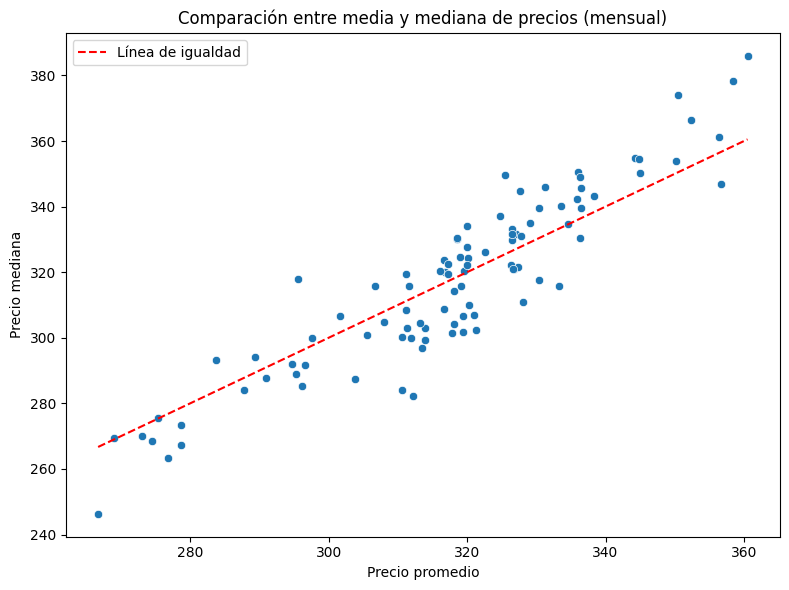

,price_mean,price_median,price_std,price_cv
count,96.000000,96.000000,96.000000,96.000000
mean,317.601115,317.288958,97.858033,0.308849
std,20.533300,26.832268,6.659005,0.022145
min,266.704286,246.315000,81.177544,0.244923
25%,310.571463,300.612500,93.396015,0.292681
50%,319.269298,319.492500,98.005070,0.309970
75%,328.312785,334.268750,102.622206,0.326960
max,360.516304,386.015000,114.993654,0.359011


In [35]:
# Agrupar: precio unitario promedio y cantidad total por producto y mes
agg = electronics_df.groupby(["vendor_id", "month"]).agg(
    price_mean=("price", "mean"),
    price_median=("price", "median"),
    price_std=("price", "std"),
    quantity_total=("quantity", "sum"),
    observations=("price", "count")
).reset_index()

# Calcular coeficiente de variación para evaluar estabilidad del precio
agg["price_cv"] = agg["price_std"] / agg["price_mean"]

# Evaluar estadísticos descriptivos globales
stats_summary = agg[["price_mean", "price_median", "price_std", "price_cv"]].describe()

# Visualizar la dispersión entre media y mediana
plt.figure(figsize=(8,6))
sns.scatterplot(data=agg, x="price_mean", y="price_median")
plt.plot([agg["price_mean"].min(), agg["price_mean"].max()],
         [agg["price_mean"].min(), agg["price_mean"].max()],
         color="red", linestyle="--", label="Línea de igualdad")
plt.xlabel("Precio promedio")
plt.ylabel("Precio mediana")
plt.title("Comparación entre media y mediana de precios (mensual)")
plt.legend()
plt.tight_layout()
plt.show()

stats_summary


# Elasticidad

In [36]:
# Quiero entender cómo afectan los precios a la demanda

In [37]:
# Agrupar: precio unitario promedio y cantidad total por producto y mes
agg = electronics_df.groupby(["product_id", "month"]).agg(
    price_mean=("price", "mean"),
    price_median=("price", "median"),
    price_std=("price", "std"),
    quantity_total=("quantity", "sum"),
    observations=("price", "count")
).reset_index()

In [38]:

# Crear columnas logarítmicas
agg["log_price"] = np.log(agg["price_mean"])
agg["log_quantity"] = np.log(agg["quantity_total"])

# Filtrar filas válidas (sin -inf o NaN)
valid = agg[agg[["log_price", "log_quantity"]].notnull().all(axis=1)]

# Ajustar regresión log-log
model = smf.ols("log_quantity ~ log_price", data=valid).fit()

# Mostrar resumen del modelo
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_quantity   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     18.59
Date:                Sat, 29 Mar 2025   Prob (F-statistic):           3.38e-05
Time:                        02:13:24   Log-Likelihood:                 17.863
No. Observations:                 120   AIC:                            -31.73
Df Residuals:                     118   BIC:                            -26.15
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.7844      1.555      7.576      0.000       8.704      14.865
log_price     -1.1646      0.270     -4.312      0.000      -1.700      -0.630
==============================================================================
Omnibus:                        0.396   Durbin-Watson:                   1.351
Prob(Omnibus):                  0.821   Jarque-Bera (JB):                0.520
Skew:                          -0.122   Prob(JB):                        0.771
Kurtosis:                       2.790   Cond. No.                         481.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
# Precios elásticos: Por cada 1% de incremento en el precio, habrá una disminución del 1.16% en la demanda

## Producto - Elasticidad

In [40]:
# Agrupar: precio unitario promedio y cantidad total por producto y mes
agg = electronics_df.groupby(["product_id", "month"]).agg(
    price_mean=("price", "mean"),
    price_median=("price", "median"),
    price_std=("price", "std"),
    quantity_total=("quantity", "sum"),
    observations=("price", "count")
).reset_index()

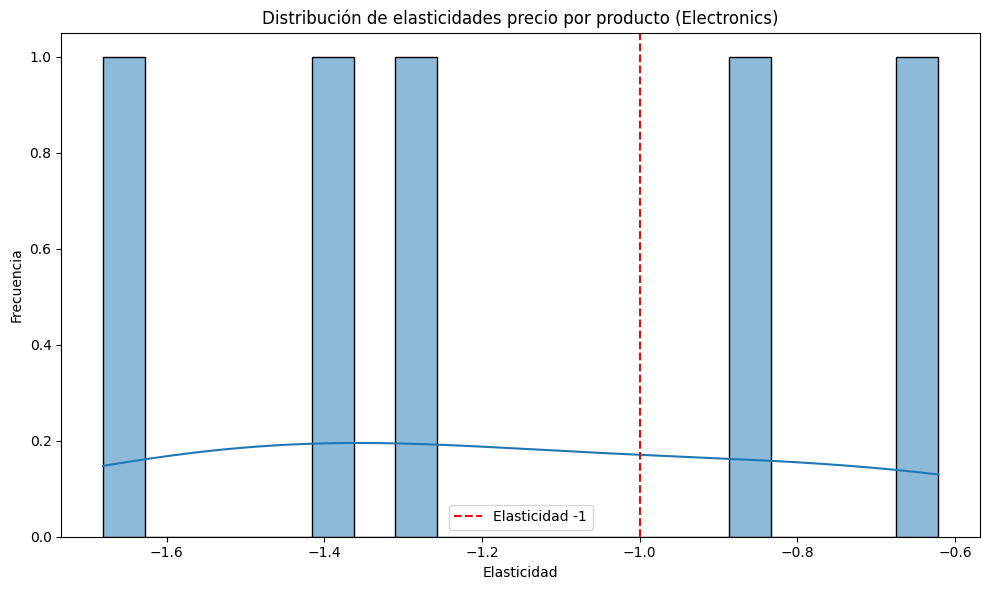

,product_id,elasticity,p_value,r_squared,n_obs
4,E199,-1.680668,0.007624,0.281683,24
1,E169,-1.398730,0.004448,0.313369,24
0,E138,-1.302734,0.090147,0.124972,24
3,E193,-0.844490,0.333617,0.042533,24
2,E179,-0.621151,0.226291,0.065802,24


In [41]:

product_counts = agg["product_id"].value_counts()

# Almacenar resultados
elasticity_results = []

# Ejecutar regresión por producto
for pid in product_counts.index :
    data = agg[agg["product_id"] == pid].copy()
    data = data[data[["price_mean", "quantity_total"]].notnull()]
    data["log_price"] = np.log(data["price_mean"])
    data["log_quantity"] = np.log(data["quantity_total"])
    
    if len(data) >= 4:
        model = smf.ols("log_quantity ~ log_price", data=data).fit()
        elasticity_results.append({
            "product_id": pid,
            "elasticity": model.params["log_price"],
            "p_value": model.pvalues["log_price"],
            "r_squared": model.rsquared,
            "n_obs": len(data)
        })

# Convertir a DataFrame
elasticity_df = pd.DataFrame(elasticity_results)

# Mostrar resumen de elasticidades
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.histplot(elasticity_df["elasticity"], kde=True, bins=20)
plt.axvline(x=-1, color="red", linestyle="--", label="Elasticidad -1")
plt.title("Distribución de elasticidades precio por producto (Electronics)")
plt.xlabel("Elasticidad")
plt.ylabel("Frecuencia")
plt.legend()
plt.tight_layout()
plt.show()

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
elasticity_df.sort_values(by="elasticity")


In [42]:
# Productos más inelásticos: E193 , E179 

In [43]:
#E199 y E169 son productos con alta sensibilidad al precio, y sus coeficientes son estadísticamente significativos (p < 0.01).

#E138 tiene una elasticidad alta pero no tan significativa (p ≈ 0.09).

#E193 y E179 tienen una demanda más inelástica y no significativa → probablemente influenciados por otros factores (marca, promociones, estacionalidad).

## Vendor - Elasticidad 

In [44]:
# Necesito saber qué vendedores afectan menos su demanda cuando modifican sus precios

In [45]:
# Agrupar: precio unitario promedio y cantidad total por producto y mes
agg = electronics_df.groupby(["vendor_id", "month"]).agg(
    price_mean=("price", "mean"),
    price_median=("price", "median"),
    price_std=("price", "std"),
    quantity_total=("quantity", "sum"),
    observations=("price", "count")
).reset_index()

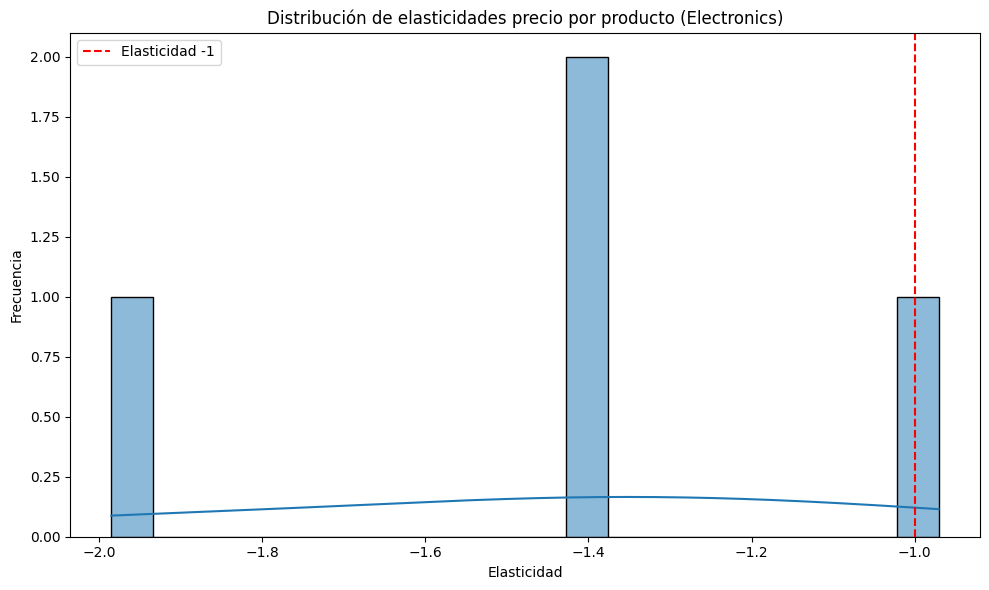

,vendor_id,elasticity,p_value,r_squared,n_obs
3,V004,-1.985179,0.011494,0.256831,24
1,V002,-1.424519,0.018759,0.226419,24
0,V001,-1.380677,0.089614,0.125360,24
2,V003,-0.970546,0.089034,0.125785,24


In [46]:

product_counts = agg["vendor_id"].value_counts()

# Almacenar resultados
elasticity_results = []

# Ejecutar regresión por producto
for pid in product_counts.index :
    data = agg[agg["vendor_id"] == pid].copy()
    data = data[data[["price_mean", "quantity_total"]].notnull()]
    data["log_price"] = np.log(data["price_mean"])
    data["log_quantity"] = np.log(data["quantity_total"])
    
    if len(data) >= 4:
        model = smf.ols("log_quantity ~ log_price", data=data).fit()
        elasticity_results.append({
            "vendor_id": pid,
            "elasticity": model.params["log_price"],
            "p_value": model.pvalues["log_price"],
            "r_squared": model.rsquared,
            "n_obs": len(data)
        })

# Convertir a DataFrame
elasticity_df = pd.DataFrame(elasticity_results)

# Mostrar resumen de elasticidades
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.histplot(elasticity_df["elasticity"], kde=True, bins=20)
plt.axvline(x=-1, color="red", linestyle="--", label="Elasticidad -1")
plt.title("Distribución de elasticidades precio por producto (Electronics)")
plt.xlabel("Elasticidad")
plt.ylabel("Frecuencia")
plt.legend()
plt.tight_layout()
plt.show()

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
elasticity_df.sort_values(by="elasticity")


In [47]:
# Vendors con inelasticidad: V001, V003 
# Estos vendedores no modifican su demanda cuando cambian los precios 

# Forecasting 

## Entrenamiento del modelo

In [48]:
# Reagrupar mensualmente
monthly_features = electronics_df.groupby("month").agg(
    revenue=("revenue", "sum"),
    avg_price=("price", "mean"),
    quantity=("quantity", "sum"),
    orders = ('order_id', 'nunique'),
    costumers = ('customer_id', 'nunique')
).reset_index()

## Asegurar que monthly_features tenga las columnas necesarias
monthly_features["month_num"] = monthly_features["month"].dt.month
monthly_features["year"] = monthly_features["month"].dt.year

# Definir X y y sin medias móviles
X = monthly_features[["avg_price", "quantity", 'orders','costumers', "month_num", "year"]]
y = monthly_features["revenue"]

# Dividir en train/test (últimos 6 meses para test)
X_train = X.iloc[:-6]
X_test = X.iloc[-6:]
y_train = y.iloc[:-6]
y_test = y.iloc[-6:]


lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

# Calcular métricas
metrics_basic = {
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
    "MAPE": mean_absolute_percentage_error(y_test, y_pred),
    "R²": r2_score(y_test, y_pred)
}

import pandas as pd
metrics_basic_df = pd.DataFrame([metrics_basic])
metrics_basic_df

,RMSE,MAPE,R²
0,3343.090147,0.011148,0.945435


In [49]:
# Reagrupar mensualmente
monthly_features = electronics_df.groupby("month").agg(
    revenue=("revenue", "sum"),
    avg_price=("price", "mean"),
    quantity=("quantity", "sum")
   # orders = ('order_id', 'nunique')
).reset_index()

## Asegurar que monthly_features tenga las columnas necesarias
monthly_features["month_num"] = monthly_features["month"].dt.month
monthly_features["year"] = monthly_features["month"].dt.year

# Definir X y y sin medias móviles
X = monthly_features[["avg_price", "quantity", "month_num", "year"]]
y = monthly_features["revenue"]

# Dividir en train/test (últimos 6 meses para test)
X_train = X.iloc[:-6]
X_test = X.iloc[-6:]
y_train = y.iloc[:-6]
y_test = y.iloc[-6:]


lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

# Guardar el modelo en un archivo .pkl
model_path = "regresion_lineal_revenue_model.pkl"
with open(model_path, "wb") as f:
    pickle.dump(lr_model, f)

# Calcular métricas
metrics_basic = {
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
    "MAPE": mean_absolute_percentage_error(y_test, y_pred),
    "R²": r2_score(y_test, y_pred)
}

import pandas as pd
metrics_basic_df = pd.DataFrame([metrics_basic])


In [50]:
# Metricas
metrics_basic_df

,RMSE,MAPE,R²
0,2028.325595,0.005628,0.979914


### Prediccion

In [51]:
# Utilizando media movil 12

In [52]:


# Crear DataFrame con fechas futuras
future_months = pd.date_range(start="2024-01-01", periods=12, freq="MS")
future_df = pd.DataFrame({
    "month": future_months,
    "month_num": future_months.month,
    "year": future_months.year
})

# Calcular manualmente la media móvil de 12 meses anteriores para cada mes futuro
future_avg_prices = []
future_quantities = []

for m in future_months:
    mask = (monthly_features["month"] >= (m - pd.DateOffset(months=12))) & (monthly_features["month"] < m)
    past_data = monthly_features[mask]
    future_avg_prices.append(past_data["avg_price"].mean())
    future_quantities.append(past_data["quantity"].mean())

future_df["avg_price"] = future_avg_prices
future_df["quantity"] = future_quantities

In [53]:

# Predecir con el modelo entrenado
X_future = future_df[["avg_price", "quantity", "month_num", "year"]]
future_df["revenue_forecast"] = lr_model.predict(X_future)

future_df

,month,month_num,year,avg_price,quantity,revenue_forecast
0,2024-01-01,1,2024,308.332614,942.666667,289113.297023
1,2024-02-01,2,2024,307.356880,928.545455,283562.827536
2,2024-03-01,3,2024,305.217271,930.600000,282234.437866
3,2024-04-01,4,2024,302.884833,934.666667,281386.820411
4,2024-05-01,5,2024,299.245343,943.125000,280769.393466
5,2024-06-01,6,2024,296.387276,936.285714,275863.977030
6,2024-07-01,7,2024,291.921246,942.833333,273856.738891
7,2024-08-01,8,2024,287.924948,940.800000,269473.250665
8,2024-09-01,9,2024,283.587750,959.250000,271483.383013
9,2024-10-01,10,2024,282.021206,952.000000,267637.267937


In [54]:

# Preparar histórico
historical = monthly_features[["month", "revenue"]].rename(columns={"revenue": "value"})
historical["type"] = "Histórico"

# Forecast con media móvil
future_plot = future_df[["month", "revenue_forecast"]].rename(columns={"revenue_forecast": "value"})
future_plot["type"] = "Forecast 2024"

# Unir ambos
combined = pd.concat([historical, future_plot])

# Graficar
fig = go.Figure()

for t in combined["type"].unique():
    subset = combined[combined["type"] == t]
    fig.add_trace(go.Scatter(
        x=subset["month"], y=subset["value"],
        mode="lines+markers",
        name=t
    ))

fig.update_layout(
    title="Histórico de Revenue + Forecast 2024 (Regresión Lineal con Media Móvil)",
    xaxis_title="Mes",
    yaxis_title="Revenue",
    height=600
)

fig.show()


### Predicción con ARIMAS en 'avg_price' y 'quantity' 

In [55]:

# Forecast ARIMA para avg_price
avg_price_series = monthly_features.set_index("month")["avg_price"]
avg_price_model = ARIMA(avg_price_series, order=(1, 1, 1)).fit()
avg_price_forecast = avg_price_model.forecast(steps=12)
avg_price_forecast.index = pd.date_range(start=avg_price_series.index[-1] + pd.offsets.MonthBegin(1), periods=12, freq="MS")

# Forecast ARIMA para quantity
quantity_series = monthly_features.set_index("month")["quantity"]
quantity_model = ARIMA(quantity_series, order=(1, 1, 1)).fit()
quantity_forecast = quantity_model.forecast(steps=12)
quantity_forecast.index = avg_price_forecast.index

# Crear DataFrame de predicción
future_df = pd.DataFrame({
    "month": avg_price_forecast.index,
    "avg_price": avg_price_forecast.values,
    "quantity": quantity_forecast.values,
    "month_num": avg_price_forecast.index.month,
    "year": avg_price_forecast.index.year
})

# Predecir revenue con forecast ARIMA de avg_price y quantity
X_future = future_df[["avg_price", "quantity", "month_num", "year"]]
future_df["revenue_forecast"] = lr_model.predict(X_future)

future_df

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency i

,month,avg_price,quantity,month_num,year,revenue_forecast
0,2024-01-01,275.937227,952.613509,1,2024,262426.429028
1,2024-02-01,279.412120,940.366566,2,2024,261603.759014
2,2024-03-01,276.632701,943.805583,3,2024,260137.405631
3,2024-04-01,278.855840,942.839886,4,2024,261852.527516
4,2024-05-01,277.077646,943.111060,5,2024,260274.119087
5,2024-06-01,278.499948,943.034912,6,2024,261540.334200
6,2024-07-01,277.362309,943.056295,7,2024,260472.211132
7,2024-08-01,278.272258,943.050291,8,2024,261287.806065
8,2024-09-01,277.544428,943.051977,9,2024,260592.039248
9,2024-10-01,278.126588,943.051503,10,2024,261106.453821


In [56]:

# Preparar histórico
historical = monthly_features[["month", "revenue"]].rename(columns={"revenue": "value"})
historical["type"] = "Histórico"

# Forecast con media móvil
future_plot = future_df[["month", "revenue_forecast"]].rename(columns={"revenue_forecast": "value"})
future_plot["type"] = "Forecast 2024"

# Unir ambos
combined = pd.concat([historical, future_plot])

# Graficar
fig = go.Figure()

for t in combined["type"].unique():
    subset = combined[combined["type"] == t]
    fig.add_trace(go.Scatter(
        x=subset["month"], y=subset["value"],
        mode="lines+markers",
        name=t
    ))

fig.update_layout(
    title="Histórico de Revenue + Forecast 2024 (Regresión Lineal con Media Móvil)",
    xaxis_title="Mes",
    yaxis_title="Revenue",
    height=600
)

fig.show()


In [57]:
# Rellenar NaNs manualmente usando media móvil acumulativa extendida
for i in range(len(future_df)):
    if pd.isna(future_df.loc[i, "avg_price"]):
        if i >= 6:
            future_df.loc[i, "avg_price"] = future_df.loc[i-6:i-1, "avg_price"].mean()
        else:
            future_df.loc[i, "avg_price"] = future_df.loc[:i-1, "avg_price"].mean()
    if pd.isna(future_df.loc[i, "quantity"]):
        if i >= 6:
            future_df.loc[i, "quantity"] = future_df.loc[i-6:i-1, "quantity"].mean()
        else:
            future_df.loc[i, "quantity"] = future_df.loc[:i-1, "quantity"].mean()

# Predecir con modelo ya entrenado
X_future_all = future_df[["avg_price", "quantity", "month_num", "year"]]
future_df["revenue_forecast"] = lr_model.predict(X_future_all)

# Preparar histórico
historical = monthly_features[["month", "revenue"]].rename(columns={"revenue": "value"})
historical["type"] = "Histórico"

# Forecast
future_plot = future_df[["month", "revenue_forecast"]].rename(columns={"revenue_forecast": "value"})
future_plot["type"] = "Forecast 2024"

# Unir para graficar
combined = pd.concat([historical, future_plot])

# Graficar con Plotly
import plotly.graph_objects as go

fig = go.Figure()
for t in combined["type"].unique():
    subset = combined[combined["type"] == t]
    fig.add_trace(go.Scatter(
        x=subset["month"], y=subset["value"],
        mode="lines+markers",
        name=t
    ))

fig.update_layout(
    title="Histórico de Revenue + Forecast 2024 (Media Móvil 6 Meses Extendida)",
    xaxis_title="Mes",
    yaxis_title="Revenue",
    height=600
)

fig.show()


## Probando otros modelos

In [58]:

# Preparar serie
monthly_series = monthly_features.set_index("month")["revenue"]

# Últimos 6 meses para test
train_final = monthly_series.iloc[:-6]
test_final = monthly_series.iloc[-6:]

# Entrenar ARIMA
arima_model_m = ARIMA(train_final, order=(1, 1, 1)).fit()
arima_pred_m = arima_model_m.forecast(steps=6)

# Entrenar SARIMA con estacionalidad anual (12)
sarima_model_m = SARIMAX(train_final, order=(1, 1, 1), seasonal_order=(0, 0, 1, 12)).fit()
sarima_pred_m = sarima_model_m.forecast(steps=6)

# Prophet
prophet_df_m = monthly_features[["month", "revenue"]].rename(columns={"month": "ds", "revenue": "y"})
prophet_train_m = prophet_df_m[prophet_df_m["ds"] <= test_final.index.min()]
prophet_model_m = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False,  holidays_prior_scale = 3, seasonality_prior_scale= 5)
prophet_model_m.fit(prophet_train_m)
future_m = prophet_model_m.make_future_dataframe(periods=6, freq="MS")
forecast_m = prophet_model_m.predict(future_m)
prophet_pred_m = forecast_m.set_index("ds").loc[test_final.index]["yhat"]

# XGBoost
feature_cols = ["avg_price", "quantity", "month_num", "year"]
X = monthly_features[feature_cols]
y = monthly_features["revenue"]
X_train_m = X.iloc[:-6]
X_test_m = X.iloc[-6:]
y_train_m = y.iloc[:-6]
y_test_m = y.iloc[-6:]

xgb_model_m = XGBRegressor(n_estimators=100, objective='reg:squarederror')
xgb_model_m.fit(X_train_m, y_train_m)
xgb_pred_m = pd.Series(xgb_model_m.predict(X_test_m), index=test_final.index)

# Comparar resultados
results_m = pd.DataFrame({
    "Actual": test_final,
    "ARIMA": arima_pred_m,
    "SARIMA": sarima_pred_m,
    "Prophet": prophet_pred_m,
    "XGBoost": xgb_pred_m
})

# Calcular métricas
metrics_m = {}
for model in ["ARIMA", "SARIMA", "Prophet", "XGBoost"]:
    rmse = np.sqrt(mean_squared_error(results_m["Actual"], results_m[model]))
    mape = mean_absolute_percentage_error(results_m["Actual"], results_m[model])
    metrics_m[model] = {"RMSE": rmse, "MAPE": mape}

metrics_m_df = pd.DataFrame(metrics_m).T.sort_values("RMSE")
metrics_m_df


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency i

,RMSE,MAPE
ARIMA,19633.769899,0.062570
SARIMA,23319.473113,0.069410
Prophet,46066.848880,0.110570
XGBoost,56943.626329,0.203787


In [59]:
results_m

,Actual,ARIMA,SARIMA,Prophet,XGBoost
2023-07-01,298676.50,289766.570361,287080.351963,298677.944741,331425.75000
2023-08-01,264584.36,288643.540297,290303.445961,365607.101434,326330.25000
2023-09-01,280145.50,289071.815060,273135.078987,278147.304518,331425.75000
2023-10-01,270883.21,288908.489715,288796.166378,305613.064252,331425.75000
2023-11-01,283691.95,288970.774889,281058.108629,282723.134483,331425.84375
2023-12-01,253986.72,288947.022036,299702.010619,290266.727448,331425.75000


In [60]:
# Agregar métricas mensuales
monthly_features = electronics_df.groupby("month").agg(
    revenue=("revenue", "sum")
).reset_index()

# Reentrenar ARIMA con todo el histórico
full_series = monthly_features[monthly_features['month'] >= '2023-01-01'].set_index("month")["revenue"]
arima_model_final = ARIMA(full_series, order=(1, 1, 1)).fit()

# Forecast para los 12 meses de 2024
forecast_arima_2024 = arima_model_final.forecast(steps=12)
forecast_arima_2024.index = pd.date_range(start=full_series.index[-1] + pd.offsets.MonthBegin(1), periods=12, freq="MS")

forecast_arima_2024.reset_index().rename(columns={"index": "month", 'predicted_mean': "revenue_forecast"})


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



,month,revenue_forecast
0,2024-01-01,258912.148891
1,2024-02-01,258555.100991
2,2024-03-01,258580.983651
3,2024-04-01,258579.107399
4,2024-05-01,258579.243410
5,2024-06-01,258579.233550
6,2024-07-01,258579.234265
7,2024-08-01,258579.234213
8,2024-09-01,258579.234217
9,2024-10-01,258579.234216


In [61]:
#sarima_model_final = SARIMAX(full_series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()
forecast_sarima_2024 = sarima_model_m.forecast(steps=12)
forecast_sarima_2024.index = pd.date_range(start=full_series.index[-1] + pd.offsets.MonthBegin(1), periods=12, freq="MS")

# Preparar histórico
historical = monthly_features[["month", "revenue"]].copy()
historical["model"] = "Histórico"
historical.rename(columns={"revenue": "value"}, inplace=True)

# ARIMA
arima_line = forecast_arima_2024.reset_index()
arima_line.columns = ["month", "value"]
arima_line["model"] = "ARIMA"

# SARIMA
sarima_line = forecast_sarima_2024.reset_index()
sarima_line.columns = ["month", "value"]
sarima_line["model"] = "SARIMA"


# Unir todo
plot_df = pd.concat([historical, arima_line, sarima_line])

# Graficar
fig = px.line(
    plot_df,
    x="month",
    y="value",
    color="model",
    markers=True,
    title="Ingreso mensual: Histórico + Predicciones ARIMA, SARIMA",
    labels={"month": "Mes", "value": "Revenue", "model": "Modelo"}
)

fig.update_layout(height=600)
fig.show()


## Estacionalidad

02:13:29 - cmdstanpy - INFO - Chain [1] start processing
02:13:35 - cmdstanpy - INFO - Chain [1] done processing


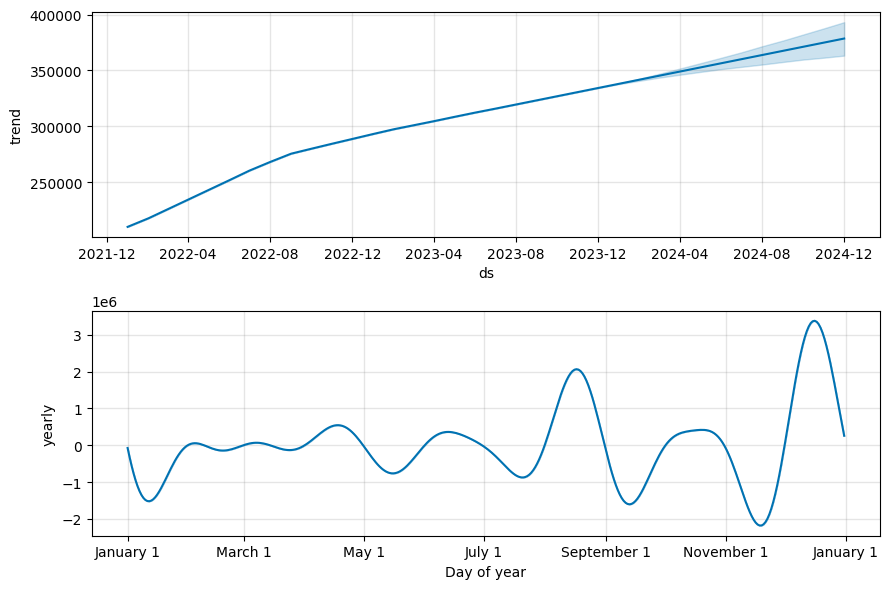

In [62]:

monthly_electronics = electronics_df.groupby("month")["revenue"].sum().reset_index()
monthly_electronics.columns = ["ds", "y"]

# Crear y ajustar modelo Prophet
model = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False,  holidays_prior_scale = 3, seasonality_prior_scale= 5)
model.fit(monthly_electronics)

# Crear DataFrame futuro (12 meses)
future = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(future)

# Visualizar componentes: tendencia + estacionalidad
fig = model.plot_components(forecast)
plt.tight_layout()
plt.show()


# Experimento 

## Hipótesis

In [63]:
#Incrementar levemente el precio de productos electrónicos inelásticos (E193, 138, E179), y disminución de precio en productos más elásticos (E199, E169)
# Aplicar una campaña de reactivación en clientes inactivos (mas de 60 días de inactividad) para vendors afectados (V001, V003)
#puede aumentar el revenue sin reducir significativamente el volumen de ventas ni la recurrencia.

## Objetivo

In [64]:
# Evaluar si una estrategia combinada de pricing + retargeting logra mejorar:

#Revenue
#Ticket promedio
#Eficiencia de vendors

## Ajuste de precios|

In [65]:
elasticity_df.sort_values(by="elasticity")


,vendor_id,elasticity,p_value,r_squared,n_obs
3,V004,-1.985179,0.011494,0.256831,24
1,V002,-1.424519,0.018759,0.226419,24
0,V001,-1.380677,0.089614,0.125360,24
2,V003,-0.970546,0.089034,0.125785,24


Para definir cuánto aumentar el precio de un producto con demanda inelástica, podemos partir de la fórmula de ingreso marginal:

$$
\%\ \Delta \text{Revenue} = \left(1 + \frac{1}{E_p} \right) \cdot \%\ \Delta \text{Precio}
$$

Reorganizando para encontrar el ajuste de precio necesario para un aumento deseado en revenue:

$$
\%\ \Delta \text{Precio} = \frac{\%\ \Delta \text{Revenue deseado}}{1 + \frac{1}{E_p}}
$$

Como esta fórmula puede volverse inestable con valores de $E_p$ cercanos a 0 o no significativos (p-value alto), usamos una estrategia conservadora basada en tramos:

| Elasticidad estimada (|Ep|) | Tipo de demanda           | Ajuste sugerido | \
|----------------------------|----------------------------|------------------| \
| < 0.5                      | Muy inelástica             | +10% precio      | \
| 0.5 – 0.9                  | Moderadamente inelástica   | **+5% precio**   | \
| ≥ 1.0                      | Elástica                   | -5% precio       | \

**Aplicación concreta**:

- Producto **E193** (Ep = -0.84) → +5%
- Producto **E179** (Ep = -0.62) → +5%

Estos aumentos buscan **recuperar revenue sin dañar volumen**, ya que los productos tienen baja sensibilidad al precio.


In [66]:
#Disminución del 7% en E199 provocaría un 11.7% de incremento en demanda 'quantity'
#Disminución del 7% en E169 provocaría un 9.7% de incremento en demanda 'quantity'
#Incremento del 5% en E179 y E193 no afectaría la demanda 

## Usuarios Inactivos

In [67]:

target_vendors_df = electronics_df[electronics_df["vendor_id"].isin(["V001", "V003"])]

# Última compra por cliente y vendor
last_purchase = target_vendors_df.groupby(["customer_id", "vendor_id"])["order_date"].max().reset_index()
last_purchase["inactive_days"] = (df["order_date"].max() - last_purchase["order_date"]).dt.days


<Axes: >

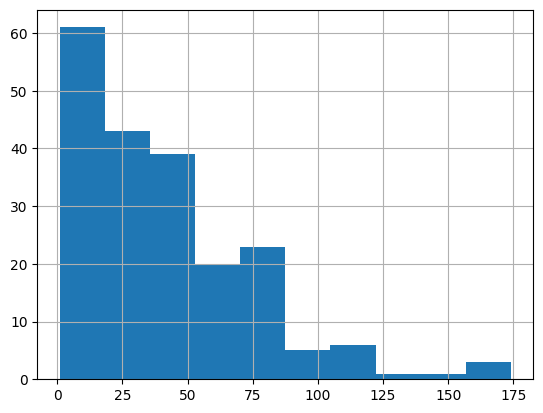

In [68]:
last_purchase['inactive_days'].hist()

In [69]:

# Seleccionar clientes inactivos por más de 30 días con V001 y V003
inactive_customers = last_purchase[last_purchase["inactive_days"] > 30]



In [70]:
from statsmodels.stats.power import TTestIndPower

# Supuestos para el cálculo de tamaño de muestra
# Basado en revenue promedio y desviación estándar de ventas de clientes inactivos
sample_revenue = electronics_df[
    (electronics_df["vendor_id"].isin(["V001", "V003"])) &
    (electronics_df["customer_id"].isin(inactive_customers["customer_id"]))
].groupby("customer_id")["revenue"].sum()

mean_sales = sample_revenue.mean()
std_sales = sample_revenue.std()

# Supuesto de efecto mínimo detectable (por ejemplo, un 10% del promedio de ventas)
effect_size_abs = 0.10 * mean_sales

# Calcular el efecto estandarizado (Cohen's d)
cohens_d = effect_size_abs / std_sales

# Power analysis
analysis = TTestIndPower()
sample_size = analysis.solve_power(effect_size=cohens_d, alpha=0.05, power=0.8, alternative='two-sided')

# Mostrar resultado
import pandas as pd
result = pd.DataFrame({
    "Media de ventas": [mean_sales],
    "Desviación estándar": [std_sales],
    "Efecto detectable (10%)": [effect_size_abs],
    "Cohen's d": [cohens_d],
    "Tamaño mínimo por grupo": [np.ceil(sample_size)]
})
result


,Media de ventas,Desviación estándar,Efecto detectable (10%),Cohen's d,Tamaño mínimo por grupo
0,30672.936329,6186.400236,3067.293633,0.495812,65.0


In [71]:
# Analizar diferentes tamaños de efecto (5%, 7.5%, 10%, 12.5%, 15%)
effect_sizes_pct = [0.05, 0.075, 0.10, 0.125, 0.15]
effect_sizes_abs = [pct * mean_sales for pct in effect_sizes_pct]
cohens_ds = [e / std_sales for e in effect_sizes_abs]
sample_sizes = [
    analysis.solve_power(effect_size=d, alpha=0.05, power=0.8, alternative='two-sided')
    for d in cohens_ds
]

# Crear DataFrame con los escenarios
scenarios_df = pd.DataFrame({
    "Tamaño de efecto (%)": [f"{int(p*100)}%" for p in effect_sizes_pct],
    "Diferencia absoluta ($)": effect_sizes_abs,
    "Cohen's d": cohens_ds,
    "Tamaño mínimo por grupo": np.ceil(sample_sizes).astype(int)
})

scenarios_df

,Tamaño de efecto (%),Diferencia absoluta ($),Cohen's d,Tamaño mínimo por grupo
0,5%,1533.646816,0.247906,257
1,7%,2300.470225,0.371859,115
2,10%,3067.293633,0.495812,65
3,12%,3834.117041,0.619765,42
4,15%,4600.940449,0.743719,30


In [72]:
#Tomaremos el tamaño de efecto de 12% 

In [73]:
# Asignar aleatoriamente 82 clientes con balance de grupos
np.random.seed(42)
sampled_customers_35 = inactive_customers.sample(n=84, replace=False).copy()
sampled_customers_35["grupo"] = ["Tratamiento"] * 42 + ["Control"] * 42
sampled_customers_35['grupo'].value_counts()

grupo
Tratamiento    42
Control        42
Name: count, dtype: int64